In [ ]:
!git clone https://github.com/nmorgan8/ArtisticFaces.git

Cloning into 'ArtisticFaces'...
remote: Enumerating objects: 602, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 602 (delta 0), reused 123 (delta 0), pack-reused 478
Receiving objects: 100% (602/602), 223.48 MiB | 21.26 MiB/s, done.
Resolving deltas: 100% (53/53), done.
Updating files: 100% (422/422), done.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
#/kaggle/input/gan-getting-started/monet_jpg
#/kaggle/input/gan-getting-started/photo_tfrec

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

CycleGAN
CycleGAN is a model that aims to solve the image-to-image translation problem. The goal of the image-to-image translation problem is to learn the mapping between an input image and an output image using a training set of aligned image pairs. However, obtaining paired examples isn't always feasible. CycleGAN tries to learn this mapping without requiring paired input-output images, using cycle-consistent adversarial networks.

## Setup

In [ ]:
%pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.1 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.experimental.AUTOTUNE
from sklearn.model_selection import train_test_split

import os, random, json, PIL, shutil, re

In [ ]:
!unzip ArtisticFaces/data/human_face.zip
!unzip ArtisticFaces/data/rococo.zip

Archive:  ArtisticFaces/data/human_face.zip
   creating: human_face/
  inflating: human_face/16_0_0_20170104003740977.jpg.chip.jpg  
  inflating: human_face/36_0_3_20170119180245724.jpg.chip.jpg  
  inflating: human_face/58_0_2_20170116193704928.jpg.chip.jpg  
  inflating: human_face/53_1_0_20170110143534851.jpg.chip.jpg  
  inflating: human_face/35_0_3_20170119201304861.jpg.chip.jpg  
  inflating: human_face/23_1_0_20170117142807780.jpg.chip.jpg  
  inflating: human_face/36_1_4_20170104172843788.jpg.chip.jpg  
  inflating: human_face/20_0_1_20170113132355967.jpg.chip.jpg  
  inflating: human_face/26_0_1_20170117195934763.jpg.chip.jpg  
  inflating: human_face/54_1_0_20170110141340224.jpg.chip.jpg  
  inflating: human_face/49_0_0_20170117135838690.jpg.chip.jpg  
  inflating: human_face/36_0_0_20170117135436708.jpg.chip.jpg  
  inflating: human_face/35_0_3_20170109132951262.jpg.chip.jpg  
  inflating: human_face/27_1_2_20170116171651433.jpg.chip.jpg  
  inflating: human_face/25_1_0_2017

In [ ]:
# This might not work but scared be not
!mkdir roc_holder
!mkdir human_holder

# mv -r src dest
!mv human_face human_holder
!mv rococo roc_holder

In [ ]:
train_art = tf.keras.utils.image_dataset_from_directory('roc_holder', validation_split=0.2, subset='training', seed=123, image_size=(256, 256), labels=None, batch_size=None)
test_art = tf.keras.utils.image_dataset_from_directory('roc_holder', validation_split=0.2, subset='validation', seed=123, image_size=(256, 256), labels=None, batch_size=None)

train_human = tf.keras.utils.image_dataset_from_directory('human_holder', validation_split=0.2, subset='training', seed=123, image_size=(256, 256), labels=None, batch_size=None)
test_human = tf.keras.utils.image_dataset_from_directory('human_holder', validation_split=0.2, subset='validation', seed=123, image_size=(256, 256), labels=None, batch_size=None)


Found 1039 files belonging to 1 classes.
Using 832 files for training.
Found 1039 files belonging to 1 classes.
Using 207 files for validation.
Found 2103 files belonging to 1 classes.
Using 1683 files for training.
Found 2103 files belonging to 1 classes.
Using 420 files for validation.


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256


def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image):
  image = random_jitter(image)
  image = normalize(image)
  return image

def preprocess_image_test(image):
  image = normalize(image)
  return image


In [ ]:
train_humans, train_art = train_human, train_art
test_humans, test_art = test_human, test_art

In [ ]:
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
train_humans = train_humans.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_art = train_art.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_humans = test_humans.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_art = test_art.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
# MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))

# PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))

# def count_data_items(filenames):
#     n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
#     return np.sum(n)

# n_monet_samples = count_data_items(MONET_FILENAMES)
# n_photo_samples = count_data_items(PHOTO_FILENAMES)


# print(f'Monet TFRecord files: {len(MONET_FILENAMES)}')
# print(f'Monet image files: {n_monet_samples}')
# print(f'Photo TFRecord files: {len(PHOTO_FILENAMES)}')
# print(f'Photo image files: {n_photo_samples}')

Monet TFRecord files: 0
Monet image files: 0.0
Photo TFRecord files: 0
Photo image files: 0.0


In [ ]:
# GCS_PATH ='/kaggle/input/gan-getting-started'

In [ ]:
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# buffer_size = 256
# batch_size = 1

# IMAGE_SIZE = [256, 256]

# def decode_image(image):
#     image = tf.image.decode_jpeg(image, channels=3)
#     image = (tf.cast(image, tf.float32) / 127.5) - 1
#     image = tf.reshape(image, [*IMAGE_SIZE, 3])
#     return image

# def read_tfrecord(example):
#     tfrecord_format = {
#         'image_name': tf.io.FixedLenFeature([], tf.string),
#         'image':      tf.io.FixedLenFeature([], tf.string),
#         'target':     tf.io.FixedLenFeature([], tf.string)
#     }
#     example = tf.io.parse_single_example(example, tfrecord_format)
#     image = decode_image(example['image'])
#     return image


## Create `Dataset` objects

In [ ]:
# Apply the preprocessing operations to the training data ### after this STEP IT SHOULD BE 4 dimensional
# AUTO = tf.data.experimental.AUTOTUNE

# def load_dataset(filenames, labeled=True, ordered=False):
#     dataset = tf.data.TFRecordDataset(filenames)
#     dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO).cache().shuffle(buffer_size).batch(batch_size) 
#     return dataset

# monet_ds = load_dataset(MONET_FILENAMES, labeled=True)
# photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True)

## Visualize some samples

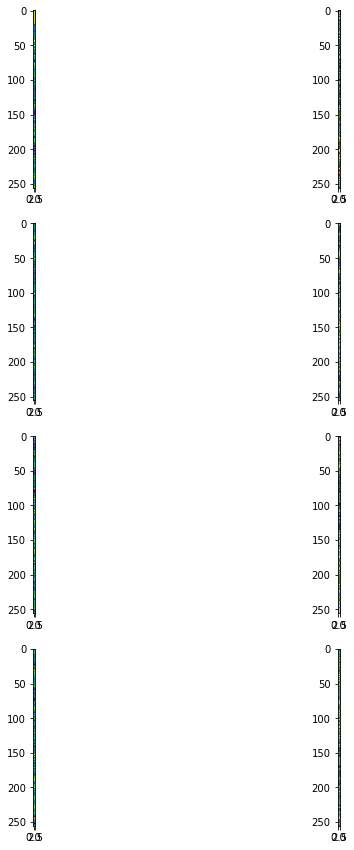

In [ ]:
# train_photo = photo_ds
# train_monet = monet_ds
# _, ax = plt.subplots(4, 2, figsize=(10, 15))
# for i, samples in enumerate(zip(train_human.take(4), train_art.take(4))):
#     photo = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
#     monet = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
#     ax[i, 0].imshow(photo)
#     ax[i, 1].imshow(monet)
# plt.show()

## Building blocks used in the CycleGAN generators and discriminators

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


## Build the generators

The generator consists of downsampling blocks: nine residual blocks
and upsampling blocks. The structure of the generator is the following:

```
c7s1-64 ==> Conv block with `relu` activation, filter size of 7
d128 ====|
         |-> 2 downsampling blocks
d256 ====|
R256 ====|
R256     |
R256     |
R256     |
R256     |-> 9 residual blocks
R256     |
R256     |
R256     |
R256 ====|
u128 ====|
         |-> 2 upsampling blocks
u64  ====|
c7s1-3 => Last conv block with `tanh` activation, filter size of 7.
```

In [ ]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    # img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    img_input = layers.Input(shape=(256,256,3), name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model


## Build the discriminators

The discriminators implement the following architecture:
`C64->C128->C256->C512`

In [ ]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    # img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    img_input = layers.Input(shape=(256,256,3), name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
gen_G.summary()

Model: "generator_G"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 generator_G_img_input (InputLa  [(None, 256, 256, 3  0          []                               
 yer)                           )]                                                                
                                                                                                  
 reflection_padding2d (Reflecti  (None, 262, 262, 3)  0          ['generator_G_img_input[0][0]']  
 onPadding2D)                                                                                     
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  9408        ['reflection_padding2d[0][0]']   
                                )                                                       

## Build the CycleGAN model

We will override the `train_step()` method of the `Model` class
for training via `fit()`. what does this mean?? 

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is photo and y is monet
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Photo to fake Monet
            fake_y = self.gen_G(real_x, training=True)
            # Monet to fake photo -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Photo to fake monet to fake photo): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Monet to fake photo to fake monet) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

## Create a callback that periodically saves generated images

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(train_photo.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()

## Train the end-to-end model

In [ ]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath
)

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [ ]:
tf.config.run_functions_eagerly(True)

832/832 [==============================] - ETA: 0s - G_loss: 3.3430 - F_loss: 4.0068 - D_X_loss: 0.1671 - D_Y_loss: 0.1949

NameError: ignored

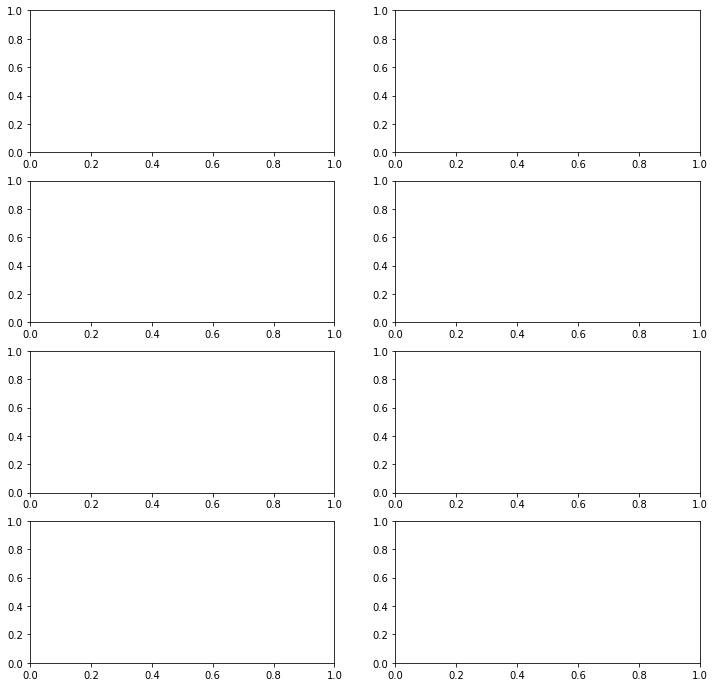

In [ ]:
# Here we will train the model for just one epoch as each epoch takes around
# 7 minutes on a single P100 backed machine.
cycle_gan_model.fit(
    tf.data.Dataset.zip((train_humans, train_art)),
    epochs=1,
    callbacks=[plotter, model_checkpoint_callback],
)

## Create submission file

In [ ]:
import PIL
! rm -rf ../images
! mkdir ../images

In [ ]:
photo_ds_unbatch = load_dataset(PHOTO_FILENAMES).take(7038)

i = 1
for img in photo_ds_unbatch:
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    print(f'{i} images saved')
    i += 1

In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")